# Extract time-series data from OpenFOAM cases

Converts temporalProbes and swakExpressions that are functions of time into continuous timeseries with no overlaps between restarts.

Dr Daniel Duke<br>
Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)<br>
Department of Mechanical & Aerospace Engineering<br>
Monash University<br>

27th March 2020

In [34]:
# Load modules
import os, re
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# Find all postProcessing and temporalProbes data in a case
def search_for_data(case_dir):
    all_files = []
    for subdir in ['postProcessing','temporalProbes']:
        if os.path.isdir(case_dir+'/'+subdir):
            for root,d_names,f_names in os.walk(case_dir+'/'+subdir):
                for f in f_names:
                    all_files.append(root+'/'+f)
    return all_files

In [35]:
# Import a series of files and truncate the time domains so they don't overlap, 
# but produce a continuous timeseries.
#
# case_dir is the root of the foam case directory
# relevant_files is a list of timeseries files to inspect
def import_and_sort(relevant_files, case_dir):
    
    # Get the start times
    start_times = []
    for f in relevant_files:
        try:
            start_times.append(float(f.split('/')[-2])) # start_time in parent directory
        except ValueError:
            start_times.append(float(f.split('.')[-1])) # start_time proxy at end of filename ie. file.NNN
    
    # Sort by start time
    sorted_files = [ relevant_files[i] for i in np.argsort(start_times) ]
    sorted_times = [ start_times[i] for i in np.argsort(start_times) ]

    data = None
    
    # Read header of 1st file to get vars
    with open(sorted_files[0],'r') as F:
        header=F.readline().strip()
        
    
    for f in sorted_files:
        print('\t'+f[len(case_dir)+1:])
        new_data = np.genfromtxt(f,skip_header=1)
        if data is None: data = new_data[...]
        else:
            # For subsequent data sets, assuming time in 1st column.
            # Back up the prior data to align with the newly imported data.
            # We assume the case was backed up some time and restarted.
            t_old_end = np.max(data[:,0])
            t_new_start = np.min(new_data[:,0])
            t_new_end = np.max(new_data[:,0])
            
            if t_old_end <= t_new_start: # no overlapping
                data = np.vstack((data, new_data))
            elif t_new_end < t_old_end: # useless fragment (failed run?)
                pass
            else: # remove old data that overlaps with the new.
                #print("data ends at",t_old_end,"and new data starts at",t_new_start)
                stop_old = np.where(data[:,0] >= t_new_start)[0][0]
                data = np.vstack((data[:stop_old,:], new_data))        
    
    return data, header

In [ ]:
def process_timeseries(case_dir):

    # swak4foam expressions are stored in postProcessing/swakExpression_varName/startTime/varName
    # temporalProbes are stored in        temporalProbes/startTime/varName

    print(case_dir)
    
    all_files = search_for_data(case_dir)

    # Get list of unique var names - assume no overlap in naming between temporalProbes and swakExpressions!
    regex = re.compile('\.[0-9]*$') # file ends in .NNNN integers
    def var_from_path(f):
        regex_result = regex.search(f)
        if regex_result is None: return os.path.basename(f)
        else: return os.path.basename(f)[:-len(regex_result.group(0))]
    
    all_vars = list(set([var_from_path(f) for f in all_files])) 

    # Set up master plot
    fig=plt.figure()
    ax=fig.add_subplot(111)
    plt.xlabel("Time")
    plt.grid(alpha=.2)
    plt.title(case_dir)

    # Set up file to save everything to case_dir
    hdf_filename = case_dir+'/timeseries_data.h5'
    if os.path.isfile(hdf_filename): 
        print('\tOverwriting old file '+hdf_filename)
        os.remove(hdf_filename)
    H=h5py.File(hdf_filename,'w')

    # Stitch together temporal portions of these for each variable
    for var in all_vars:

        # Find which files have this var
        relevant_files = [ f for f in all_files if var == var_from_path(f) ]

        # Load the data
        data, header = import_and_sort(relevant_files, case_dir)

        # Save the data
        Hds = H.create_dataset(var,data=data,compression='gzip')
        Hds.attrs['columns']=[h for h in header.split(' ') if h != '']

        # Graph this variable
        plot_stride = int(data.shape[0]/1000.) # no more than 1000pts per variable onscreen.
        if plot_stride<1: plot_stride=1
        for j in range(1,data.shape[1]):
            #ax.scatter(data[::plot_stride,0],data[::plot_stride,j],marker='.',lw=1,s=2,label=var)
            ax.plot(data[::plot_stride,0],data[::plot_stride,j],lw=1,label=var)

        #break

    H.close()
    plt.legend();
    
    return
    

<IPython.core.display.Javascript object>


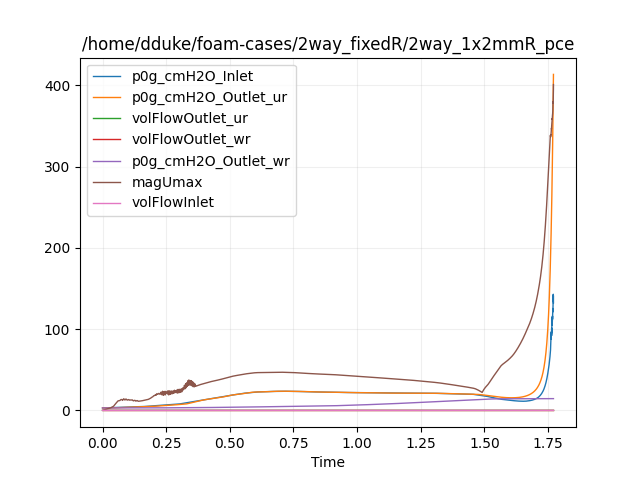

	Overwriting old file /home/dduke/foam-cases/2way_fixedR/2way_1x2mmR_pce/timeseries_data.h5
	postProcessing/swakExpression_p0g_cmH2O_Inlet/0/p0g_cmH2O_Inlet
	postProcessing/swakExpression_p0g_cmH2O_Outlet_ur/0/p0g_cmH2O_Outlet_ur
	postProcessing/swakExpression_volFlowOutlet_ur/0/volFlowOutlet_ur
	postProcessing/swakExpression_volFlowOutlet_wr/0/volFlowOutlet_wr
	postProcessing/swakExpression_p0g_cmH2O_Outlet_wr/0/p0g_cmH2O_Outlet_wr
	postProcessing/magUmax.0
	postProcessing/swakExpression_volFlowInlet/0/volFlowInlet


In [41]:
# MAIN -  run on case
process_timeseries("/home/dduke/foam-cases/2way_fixedR/2way_1x2mmR_pce")

<IPython.core.display.Javascript object>


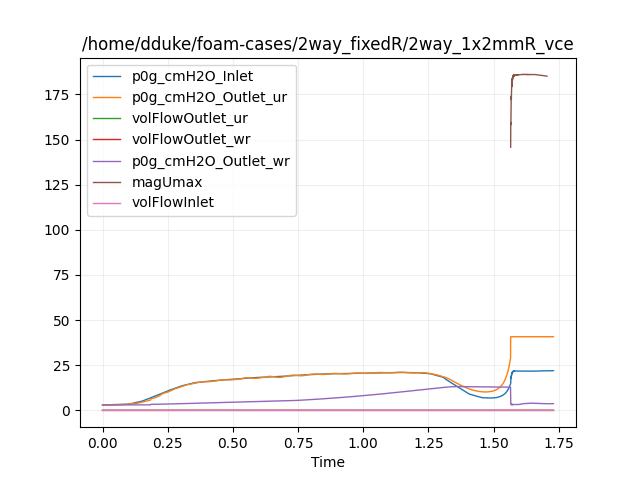

	Overwriting old file /home/dduke/foam-cases/2way_fixedR/2way_1x2mmR_vce/timeseries_data.h5
	postProcessing/swakExpression_p0g_cmH2O_Inlet/0/p0g_cmH2O_Inlet
	postProcessing/swakExpression_p0g_cmH2O_Inlet/0.1/p0g_cmH2O_Inlet
	postProcessing/swakExpression_p0g_cmH2O_Inlet/0.17/p0g_cmH2O_Inlet
	postProcessing/swakExpression_p0g_cmH2O_Inlet/0.18/p0g_cmH2O_Inlet
	postProcessing/swakExpression_p0g_cmH2O_Inlet/0.185/p0g_cmH2O_Inlet
	postProcessing/swakExpression_p0g_cmH2O_Inlet/0.205/p0g_cmH2O_Inlet
	postProcessing/swakExpression_p0g_cmH2O_Inlet/1.565/p0g_cmH2O_Inlet
	postProcessing/swakExpression_p0g_cmH2O_Outlet_ur/0/p0g_cmH2O_Outlet_ur
	postProcessing/swakExpression_p0g_cmH2O_Outlet_ur/0.1/p0g_cmH2O_Outlet_ur
	postProcessing/swakExpression_p0g_cmH2O_Outlet_ur/0.17/p0g_cmH2O_Outlet_ur
	postProcessing/swakExpression_p0g_cmH2O_Outlet_ur/0.18/p0g_cmH2O_Outlet_ur
	postProcessing/swakExpression_p0g_cmH2O_Outlet_ur/0.185/p0g_cmH2O_Outlet_ur
	postProcessing/swakExpression_p0g_cmH2O_Outlet_ur/0.205

In [43]:
process_timeseries("/home/dduke/foam-cases/2way_fixedR/2way_1x2mmR_vce")

<IPython.core.display.Javascript object>


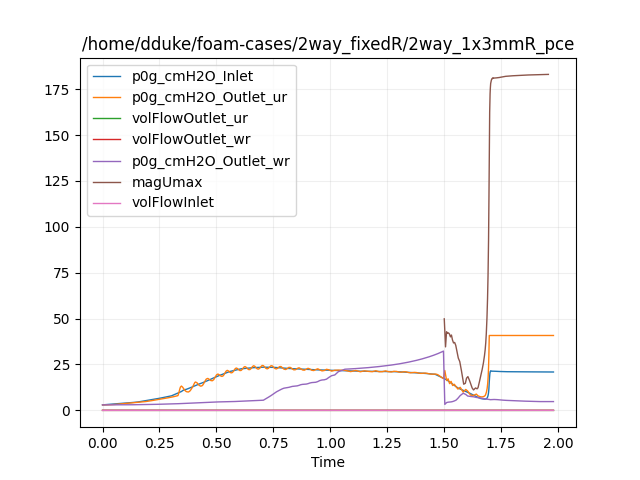

	Overwriting old file /home/dduke/foam-cases/2way_fixedR/2way_1x3mmR_pce/timeseries_data.h5
	postProcessing/swakExpression_p0g_cmH2O_Inlet/0/p0g_cmH2O_Inlet
	postProcessing/swakExpression_p0g_cmH2O_Inlet/1.5/p0g_cmH2O_Inlet
	postProcessing/swakExpression_p0g_cmH2O_Outlet_ur/0/p0g_cmH2O_Outlet_ur
	postProcessing/swakExpression_p0g_cmH2O_Outlet_ur/1.5/p0g_cmH2O_Outlet_ur
	postProcessing/swakExpression_volFlowOutlet_ur/0/volFlowOutlet_ur
	postProcessing/swakExpression_volFlowOutlet_ur/1.5/volFlowOutlet_ur
	postProcessing/swakExpression_volFlowOutlet_wr/0/volFlowOutlet_wr
	postProcessing/swakExpression_volFlowOutlet_wr/1.5/volFlowOutlet_wr
	postProcessing/swakExpression_p0g_cmH2O_Outlet_wr/0/p0g_cmH2O_Outlet_wr
	postProcessing/swakExpression_p0g_cmH2O_Outlet_wr/1.5/p0g_cmH2O_Outlet_wr
	postProcessing/magUmax.0
	postProcessing/magUmax.1
	postProcessing/swakExpression_volFlowInlet/0/volFlowInlet
	postProcessing/swakExpression_volFlowInlet/1.5/volFlowInlet


In [45]:
process_timeseries("/home/dduke/foam-cases/2way_fixedR/2way_1x3mmR_pce")

<IPython.core.display.Javascript object>


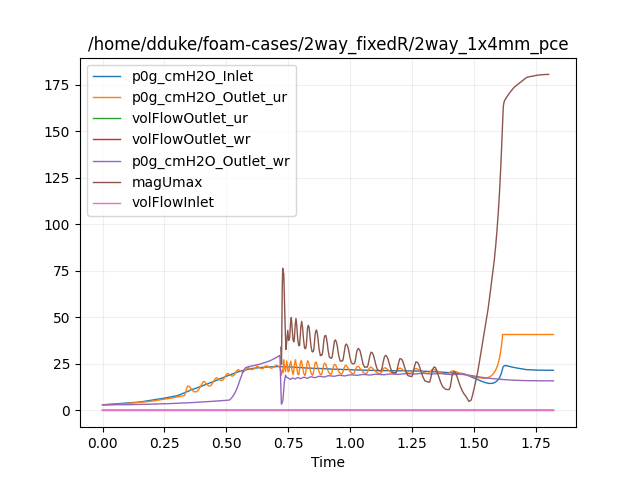

	postProcessing/swakExpression_p0g_cmH2O_Inlet/0/p0g_cmH2O_Inlet
	postProcessing/swakExpression_p0g_cmH2O_Inlet/0.72/p0g_cmH2O_Inlet
	postProcessing/swakExpression_p0g_cmH2O_Outlet_ur/0/p0g_cmH2O_Outlet_ur
	postProcessing/swakExpression_p0g_cmH2O_Outlet_ur/0.72/p0g_cmH2O_Outlet_ur
	postProcessing/swakExpression_volFlowOutlet_ur/0/volFlowOutlet_ur
	postProcessing/swakExpression_volFlowOutlet_ur/0.72/volFlowOutlet_ur
	postProcessing/swakExpression_volFlowOutlet_wr/0/volFlowOutlet_wr
	postProcessing/swakExpression_volFlowOutlet_wr/0.72/volFlowOutlet_wr
	postProcessing/swakExpression_p0g_cmH2O_Outlet_wr/0/p0g_cmH2O_Outlet_wr
	postProcessing/swakExpression_p0g_cmH2O_Outlet_wr/0.72/p0g_cmH2O_Outlet_wr
	postProcessing/magUmax.0
	postProcessing/magUmax.1
	postProcessing/swakExpression_volFlowInlet/0/volFlowInlet
	postProcessing/swakExpression_volFlowInlet/0.72/volFlowInlet


In [47]:
process_timeseries("/home/dduke/foam-cases/2way_fixedR/2way_1x4mm_pce")

In [48]:
process_timeseries("/home/dduke/foam-cases/2way_fixedR/2way_noR_pce")

<IPython.core.display.Javascript object>

	postProcessing/swakExpression_p0g_cmH2O_Inlet/0/p0g_cmH2O_Inlet
	postProcessing/swakExpression_p0g_cmH2O_Inlet/0.27/p0g_cmH2O_Inlet
	postProcessing/swakExpression_p0g_cmH2O_Inlet/1.75/p0g_cmH2O_Inlet
	postProcessing/swakExpression_p0g_cmH2O_Outlet_ur/0/p0g_cmH2O_Outlet_ur
	postProcessing/swakExpression_p0g_cmH2O_Outlet_ur/0.27/p0g_cmH2O_Outlet_ur
	postProcessing/swakExpression_p0g_cmH2O_Outlet_ur/1.75/p0g_cmH2O_Outlet_ur
	postProcessing/swakExpression_volFlowOutlet_ur/0/volFlowOutlet_ur
	postProcessing/swakExpression_volFlowOutlet_ur/0.27/volFlowOutlet_ur
	postProcessing/swakExpression_volFlowOutlet_ur/1.75/volFlowOutlet_ur
	postProcessing/swakExpression_p0g_cmH2O_Outlet_ur2/0/p0g_cmH2O_Outlet_ur2
	postProcessing/swakExpression_p0g_cmH2O_Outlet_ur2/0.27/p0g_cmH2O_Outlet_ur2
	postProcessing/swakExpression_p0g_cmH2O_Outlet_ur2/1.75/p0g_cmH2O_Outlet_ur2
	postProcessing/swakExpression_volFlowOutlet_ur2/0/volFlowOutlet_ur2
	postProcessing/swakExpression_volFlowOutlet_ur2/0.27/volFlowOutlet

In [ ]:
process_timeseries("/home/dduke/foam-cases/4way_fixedR/4way_1x2mmR_pce")

<IPython.core.display.Javascript object>

	Overwriting old file /home/dduke/foam-cases/4way_fixedR/4way_1x2mmR_pce/timeseries_data.h5
	postProcessing/swakExpression_p0g_cmH2O_Outlet_ur3/0/p0g_cmH2O_Outlet_ur3
	postProcessing/swakExpression_p0g_cmH2O_Outlet_ur3/0.03/p0g_cmH2O_Outlet_ur3
	postProcessing/swakExpression_p0g_cmH2O_Outlet_ur3/0.77/p0g_cmH2O_Outlet_ur3
	postProcessing/swakExpression_p0g_cmH2O_Outlet_ur3/0.775/p0g_cmH2O_Outlet_ur3
	postProcessing/swakExpression_p0g_cmH2O_Inlet/0/p0g_cmH2O_Inlet
	postProcessing/swakExpression_p0g_cmH2O_Inlet/0.03/p0g_cmH2O_Inlet
	postProcessing/swakExpression_p0g_cmH2O_Inlet/0.77/p0g_cmH2O_Inlet
	postProcessing/swakExpression_p0g_cmH2O_Inlet/0.775/p0g_cmH2O_Inlet
	postProcessing/swakExpression_p0g_cmH2O_Outlet_ur1/0/p0g_cmH2O_Outlet_ur1
	postProcessing/swakExpression_p0g_cmH2O_Outlet_ur1/0.03/p0g_cmH2O_Outlet_ur1
